In [1]:
from abc import ABC, abstractmethod
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


def loadFlights():
    df = pd.read_csv("../../datasets/mobility/flightradar/total-number-of-flights.csv", sep =";", low_memory=False)
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    return df

def loadApple(transportation_type="transit"):
    #select keys
    country = ["Germany", "France", "Austria", "Spain", "Italy", "Croatia", "Poland", "Brazil", "Japan", "United States", "UK", "Canada", "India", "Russia", "Belgium", "Bulgaria", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Portugal", "Romania", "Slovakia", "Slovenia", "Sweden", "United Kingdom"]
    EUs = np.sort(["Germany", "France", "Austria", "Spain", "Croatia", "Poland", "Belgium", "Bulgaria", "Czech Republic", "Denmark", "Estonia", "Finland", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Portugal", "Romania", "Slovakia", "Slovenia", "Sweden", "United Kingdom"])

    # load dataset
    df_apple = pd.read_csv("../../datasets/mobility/apple.csv", low_memory=False)
    
    # filtering
    df_filtered_apple = df_apple[(df_apple.transportation_type == transportation_type) & (
                df_apple.geo_type == "country/region") & df_apple.region.isin(country)]
    df_filtered_apple = df_filtered_apple.drop(
        ["geo_type", "transportation_type", "alternative_name", "sub-region", "country"], axis=1)
    df_filtered_apple = df_filtered_apple.pivot_table(columns='region')
    df_filtered_apple = df_filtered_apple.fillna(method="ffill")
    
    df_filtered_apple["DateTime"] = pd.to_datetime(df_filtered_apple.axes[0])
    df_filtered_apple = df_filtered_apple.set_index('DateTime')
    
    # add EU
    
    # not every EU country has transit option on apple maps
    if transportation_type == "transit":
        EUs = np.sort(["Germany", "France", "Spain", "Belgium", "Czech Republic", "Denmark", "Estonia", "Finland", "Ireland", "Italy", "Luxembourg", "Netherlands", "Slovakia", "Sweden", "United Kingdom"])
    else:
        EUs = np.sort(["Germany", "France", "Austria", "Spain", "Croatia", "Poland", "Belgium", "Bulgaria", "Czech Republic", "Denmark", "Estonia", "Finland", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Netherlands", "Portugal", "Romania", "Slovakia", "Slovenia", "Sweden", "United Kingdom"])


    df_filtered_apple["European Union"] = np.zeros(len(df_filtered_apple["Germany"]))

    df_people = pd.read_csv("../../datasets/mobility/inhabitantsEU.csv", sep =";", low_memory=False)
    total_population = 0
    for EUcountry in EUs:
        total_population = total_population + df_people.loc[df_people['Country'] == EUcountry]["Population"].to_numpy()
    
    df_people["Percentage"] = df_people["Population"]/total_population
    
    percentage = df_people.loc[df_people['Country'] == "Belgium"]["Percentage"].to_numpy()


    for EUcountry in EUs:
        percentage = df_people.loc[df_people['Country'] == EUcountry]["Percentage"].to_numpy()
        df_filtered_apple["European Union"] = df_filtered_apple["European Union"] + df_filtered_apple[EUcountry]*percentage        
    
    return df_filtered_apple

In [19]:
def plottransit(dfapple_t):
    countries_t = ["Brazil", "Canada", "European Union", "Japan", "United States"]

    ax = dfapple_t[countries_t].plot(kind='line', x_compat=True)
    plt.xticks(rotation=60)
    plt.title("Transportation Type: %s" % "Transit")
    plt.ylabel("Percentage from baseline 2020-01-13")

    fig = ax.get_figure()
    fig.savefig("../../results/predictions/transit.pdf", bbox_inches='tight')
    return fig, ax

def plottransit_ma(dfapple_t):
    countries_t = ["Brazil", "Canada", "European Union", "Japan", "United States"]
    ax = dfapple_t[countries_t].rolling(window=7).mean().plot(kind='line', x_compat=True)
    plt.xticks(rotation=60)
    plt.title("Transportation Type: %s" % "Transit")
    plt.ylabel("Percentage from Baseline 2020-01-13\nwith 7-day Moving Average Applied")

    fig = ax.get_figure()
    fig.savefig("../../results/predictions/transit_ma.pdf", bbox_inches='tight')
    return fig, ax

def plotdriving(dfapple_d):
    countries_d = ["Brazil", "Canada", "European Union", "India", "Japan", "Russia", "United States"]

    ax = dfapple_d[countries_d].plot(kind='line', x_compat=True)
    plt.xticks(rotation=60)
    plt.title("Transportation Type: %s" % "Driving")
    plt.ylabel("Percentage from Baseline 2020-01-13")

    fig = ax.get_figure()
    fig.savefig("../../results/predictions/driving.pdf", bbox_inches='tight')
    return fig, ax

def plotdriving_ma(dfapple_d):
    countries_d = ["Brazil", "Canada", "European Union", "India", "Japan", "Russia", "United States"]

    ax = dfapple_d[countries_d].rolling(window=7).mean().plot(kind='line', x_compat=True)
    plt.xticks(rotation=60)
    plt.title("Transportation Type: %s" % "Driving")
    plt.ylabel("Percentage from Baseline 2020-01-13\nwith 7-day Moving Average Applied")

    fig = ax.get_figure()
    fig.savefig("../../results/predictions/driving_ma.pdf", bbox_inches='tight')
    return fig, ax

def plotflights(df):
    normalized_data_7d = df["7-day moving average"]/np.mean(df["7-day moving average"][0:60])
    normalized_data = df["Number of flights"]/np.mean(df["Number of flights"][0:60])

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(df['DateTime'], normalized_data_7d)
    ax.plot(df['DateTime'], normalized_data)
    plt.ylabel("Total number of flights and 7-day moving average\nnormalized by mean from Jan-13 to Mar-12 2020")
    plt.xlabel("Date")
    plt.show()
    #fig = ax.get_figure()
    fig.savefig("../../results/predictions/flights.pdf", bbox_inches='tight')
    return fig, ax

def append_ma(dfapple_t,dfapple_d):
    #append moving averages
    #transit
    countries_t = ["Brazil", "Canada", "European Union", "Japan", "United States"]
    countries_d = ["Brazil", "Canada", "European Union", "India", "Japan", "Russia", "United States"]
    for country in countries_t:
        dfapple_t[country+"_ma"] = dfapple_t[country].rolling(window=7).mean()
    dfapple_t.fillna(method= "bfill")

    #driving
    for country in countries_d:
        dfapple_d[country+"_ma"] = dfapple_d[country].rolling(window=7).mean()
    dfapple_d.fillna(method= "bfill")
    return dfapple_t,dfapple_d

def vector_t(dfapple_t):
    perc_t = dict()
    countries_t = ["Brazil", "Canada", "European Union", "Japan", "United States"]
    for country in countries_t:
        perc_t[country] = dfapple_t[country+"_ma"].resample('M').mean()/100
    return perc_t

def plot_vec_t(perc_t):
    countries_t = ["Brazil", "Canada", "European Union", "Japan", "United States"]
    fig, ax = plt.subplots(figsize=(6, 4))
    early_year = ["January", "February", "March", "April", "May", "June"]
    for country in countries_t:
        ax.plot(early_year, perc_t[country], label = country)

    ax.legend()
    plt.ylabel("Transit Mobility Compared to Baseline 2020-01-13")
    plt.xlabel("Months in Early 2020")
    plt.show()
    fig.savefig("../../results/predictions/indicator_transit.pdf", bbox_inches='tight')
    return fig, ax

def vector_d(dfapple_d):
    perc_d = dict()
    countries_d = ["Brazil", "Canada", "European Union", "India", "Japan", "Russia", "United States"]
    for country in countries_d:
        perc_d[country] = dfapple_d[country+"_ma"].resample('M').mean()/100
    return perc_d

def plot_vec_d(perc_d):
    countries_d = ["Brazil", "Canada", "European Union", "India", "Japan", "Russia", "United States"]
    fig, ax = plt.subplots(figsize=(6, 4))
    early_year = ["January", "February", "March", "April", "May", "June"]
    for country in countries_d:    
        ax.plot(early_year, perc_d[country], label = country)

    ax.legend()
    plt.ylabel("Driving Mobility Compared to Baseline 2020-01-13")
    plt.xlabel("Months in Early 2020")
    plt.show()
    fig.savefig("../../results/predictions/indicator_driving.pdf", bbox_inches='tight')
    return fig, ax

def vector_nochina(perc_t, perc_d):
    # I could not find anything yet on how to combine these two "seperate" mobility sections. I use 50/50 for now
    # If there is no transit data, I simply only use driving data
    countries_t = ["Brazil", "Canada", "European Union", "Japan", "United States"]
    perc = perc_d
    for country in countries_t:
        perc[country] = (perc_t[country]+perc_d[country])/2
    return perc

def vector(perc):
    dfperc = pd.DataFrame(perc)

    jan = 1
    feb = np.mean(dfperc.loc["2020-03-31", ["Brazil", "Canada", "European Union", "United States"]])
    mar = np.mean(dfperc.loc["2020-04-30", ["Brazil", "Canada", "European Union", "United States", "India"]])
    apr = np.mean(dfperc.loc["2020-05-31"])
    may = np.mean(dfperc.loc["2020-06-30", ["European Union", "Russia", "Japan"]])
    jun = 1
    china_2020 = [jan, feb, mar, apr, may, jun]

    dfchina = pd.DataFrame({"DateTime": pd.to_datetime(["2020-01-31","2020-02-29","2020-03-31","2020-04-30","2020-05-31","2020-06-30"]), "China_ma": china_2020})
    dfchina = dfchina.set_index('DateTime')
    perc["China"] = dfchina
    countries8 = np.sort(["Brazil", "Canada", "European Union", "United States", "India", "China", "Japan", "Russia"])
    percentage = perc
    for country in countries8:
        perc[country] = perc[country].to_numpy()
    perc["China"] = perc["China"][:,0]
    return perc

def plot_full_vector(perc):
    countries_nC = np.sort(["Brazil", "Canada", "European Union", "United States", "India", "Japan", "Russia"])
    fig, ax = plt.subplots(figsize=(6, 4))
    early_year = ["January", "February", "March", "April", "May", "June"]
    for country in countries_nC:    
        ax.plot(early_year, perc_d[country], label = country)
    ax.plot(early_year, perc_d["China"], linestyle = 'dotted', label = "China")
    ax.legend()
    plt.ylabel("Mobility Indicator")
    plt.xlabel("Months in Early 2020")
    plt.show()
    fig.savefig("../../results/predictions/full_mobility_indicator.pdf", bbox_inches='tight')
    return fig, ax

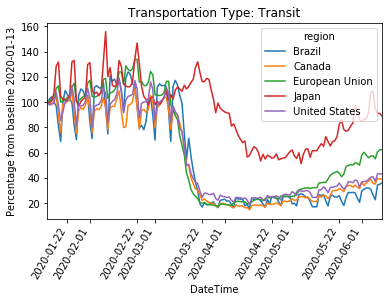

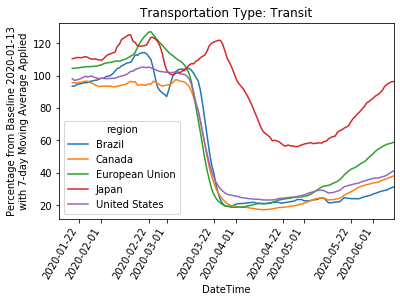

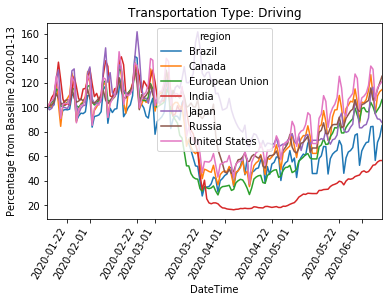

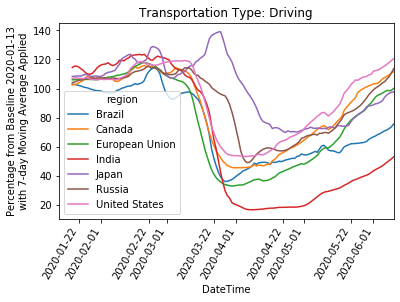

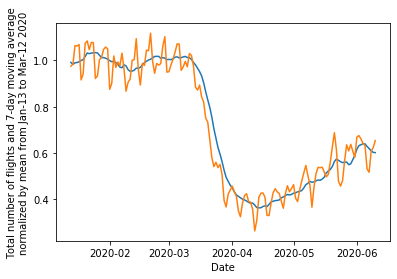

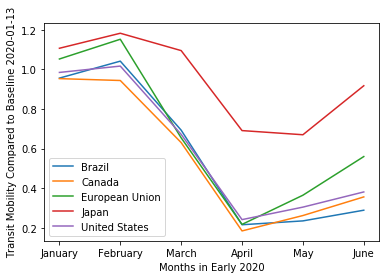

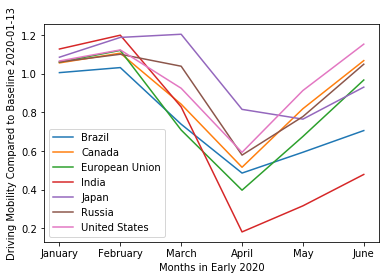

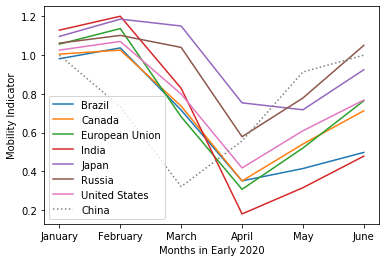

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd6f66d6cc0>)

In [20]:
dfapple = loadApple()
dfapple_t = loadApple("transit")
dfapple_d = loadApple("driving")
df = loadFlights()

plottransit(dfapple_t)
plottransit_ma(dfapple_t)
plotdriving(dfapple_d)
plotdriving_ma(dfapple_d)
plotflights(df)

dfapple_t, dfapple_d = append_ma(dfapple_t,dfapple_d)
perc_t = vector_t(dfapple_t)

plot_vec_t(perc_t)
perc_d = vector_d(dfapple_d)

plot_vec_d(perc_d)

perc = vector_nochina(perc_t, perc_d)
perc = vector(perc)

plot_full_vector(perc)